In [75]:
import numpy as np
import pandas as pd
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
from src.utils import load_data



def daily_log_returns(values):
    """Calculate log returns for each day."""
    returns = np.log(values / np.roll(values, 1))
    returns[0] = None
    return returns


class MomentumTimeSeries(Strategy):
    # Define the lookback period
    lookback = 3

    def init(self):
        # Precompute the returns
        self.returns = self.I(daily_log_returns, self.data.Close)
        self.long_short = self.I(np.sign, pd.Series(self.returns).rolling(self.lookback).mean())
        
        #self.long_short = np.roll(self.long_short, 1)
        #self.long_short[0] = None
        #self.strategy = self.long_short * self.returns

    def next(self):
        if self.long_short > 0:
            self.position.close()
            self.buy()

        elif self.long_short < 0:
            self.position.close()
            self.sell()


data = load_data('../data/XAU-USD.csv')

bt = Backtest(data, MomentumTimeSeries, cash=10000, commission=0, trade_on_close=True)
stats = bt.run()
stats

Start                     2010-01-04 00:00:00
End                       2019-12-31 00:00:00
Duration                   3648 days 00:00:00
Exposure Time [%]                   99.801272
Equity Start [$]                    10,000.00
Equity Final [$]                    17,951.19
Equity Peak [$]                     20,076.18
Return [%]                              79.51
Buy & Hold Return [%]                   35.45
Return (Ann.) [%]                    6.035119
Volatility (Ann.) [%]               15.491005
Sharpe Ratio                         0.389589
Sortino Ratio                        0.619353
Calmar Ratio                         0.230684
Max. Drawdown [%]                  -26.161889
Avg. Drawdown [%]                   -4.796349
Max. Drawdown Duration      706 days 00:00:00
Avg. Drawdown Duration       78 days 00:00:00
# Trades                                 2511
Win Rate [%]                        50.099562
Best Trade [%]                       8.495958
Worst Trade [%]                   

In [7]:
stats._strategy.long_short

_Indicator([nan, -1.,  1., ..., -1.,  1.,  1.])

In [76]:
def daily_log_returns(values):
    """Calculate returns for each day."""
    returns = np.log(values / np.roll(values, 1))
    returns[0] = None
    return returns

data['Close_1'] = np.roll(data['Close'], 1)
data['Returns'] = daily_log_returns(data['Close'])
data['Position'] = np.sign(data['Returns'].rolling(3).mean())
data['Strategy'] = data['Position'].shift(1) * data['Returns']
data

/var/folders/7p/20jlgx1s0590bspmx2fqlc8w0000gn/T/ipykernel_2174/3883244395.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  returns[0] = None


,Open,High,Low,Close,Close_1,Returns,Position,Strategy
Date,,,,,,,,
2010-01-04,1120.0000,1120.0000,1120.0000,1120.0000,1517.0100,NaN,NaN,NaN
2010-01-05,1118.6500,1118.6500,1118.6500,1118.6500,1120.0000,-0.001206,NaN,NaN
2010-01-06,1138.5000,1138.5000,1138.5000,1138.5000,1118.6500,0.017589,NaN,NaN
2010-01-07,1131.9000,1131.9000,1131.9000,1131.9000,1138.5000,-0.005814,1.0,NaN
2010-01-08,1136.1000,1136.1000,1136.1000,1136.1000,1131.9000,0.003704,1.0,0.003704
...,...,...,...,...,...,...,...,...
2019-12-24,1498.8100,1498.8100,1498.8100,1498.8100,1485.2700,0.009075,1.0,0.009075
2019-12-26,1511.2979,1511.2979,1511.2979,1511.2979,1498.8100,0.008297,1.0,0.008297
2019-12-27,1510.4167,1510.4167,1510.4167,1510.4167,1511.2979,-0.000583,1.0,-0.000583


<Axes: xlabel='Date'>

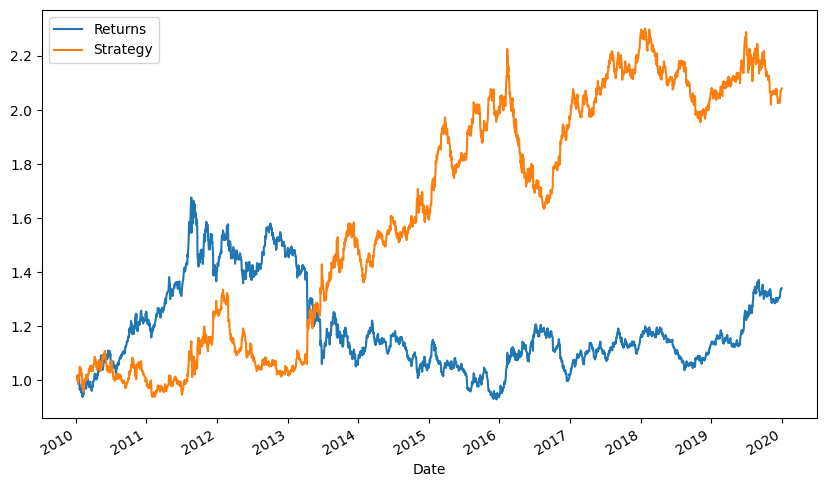

In [77]:
data[['Returns', 'Strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

In [78]:
data[['Returns', 'Strategy']].dropna().cumsum().apply(np.exp)

,Returns,Strategy
Date,,
2010-01-08,1.003711,1.003711
2010-01-11,1.018288,1.018288
2010-01-12,0.995936,0.995936
2010-01-13,1.005743,0.986225
2010-01-14,1.009674,0.990080
...,...,...
2019-12-24,1.324154,2.054835
2019-12-26,1.335187,2.071955
2019-12-27,1.334408,2.070747
